In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import StandardScaler
import wfdb  # For reading .dat and .hea files
from config import DATASET_DIR
from skmultilearn.model_selection import iterative_train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Input, ReLU, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import F1Score, AUC, Precision, Recall
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

## Download the data
This dataset is very large, will take several hours to download.

In [ ]:
!curl -O https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

In [ ]:
!unzip -q ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
!ls

## Preprocessing

In [2]:
### **Load the dataset**
# Load metadata
df = pd.read_csv(os.path.join(DATASET_DIR, "ptbxl_database.csv"))
df_labels = pd.read_csv(os.path.join(DATASET_DIR, "scp_statements.csv"))


### **Load & Preprocess ECG signals**
def load_ecg(record_name):
    """Laster ECG signalene fra .dat filene i PTB-XL datasettet"""
    file_path = os.path.join(DATASET_DIR, record_name)
    record = wfdb.rdsamp(file_path)[0]
    return record

# Loads all ECGs into a NumPy array
ecg_signals = np.array([load_ecg(f) for f in df["filename_hr"]])


### **Select relevant leads**
FOCUS_LEADS = [0,1,2,3,4,5,6,7,8,9,10,11]
FOCUS_LEAD_NAMES = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

# Extracts only the selected leads
ecg_signals = ecg_signals[:, :, FOCUS_LEADS]


### **Multi-Label Disease Annotations**
def process_labels(df, df_labels):
    """
    Creates a table where each ECG gets a 0 or 1 for each disease to indicate if that type of heart problem is present.
    Considers only those with over 50% confidence score
    """
    diagnostic_classes = ["NORM", "MI", "STTC", "CD", "HYP"]
    
    # Translates 'scp_codes' from text to classes like 'NORM' and 'MI' with confidence scores
    df["scp_codes"] = df["scp_codes"].apply(ast.literal_eval)
    expanded_rows = []
    for idx, row in df.iterrows():
        for code, value in row["scp_codes"].items():
            expanded_rows.append({"ecg_id": row["ecg_id"], "scp_code": code, "confidence": value})
    expanded_df = pd.DataFrame(expanded_rows)
    
    # Links SCP codes to disease names from another table
    expanded_df = expanded_df.merge(df_labels, left_on="scp_code", right_on="Unnamed: 0", how="left")
    expanded_df = expanded_df[(expanded_df["confidence"] >= 50) & (expanded_df["diagnostic_class"].isin(diagnostic_classes))]
    
    # Counts how many times each disease appears for each ECG
    df_labels_onehot = expanded_df.pivot_table(index="ecg_id", columns="diagnostic_class", aggfunc="size", fill_value=0)
    
    # Adds the count to the original table
    df = df.merge(df_labels_onehot, left_on="ecg_id", right_index=True, how="left").fillna(0)
    
    for col in diagnostic_classes:
        df[col] = (df[col] > 0).astype(np.float32)
    
    return df

df = process_labels(df, df_labels)


# Extract the disease labels
target_columns = ["NORM", "MI", "STTC", "CD", "HYP"]
y = df[target_columns].values.astype(np.float32)

# Verify that the labels only have values 0 or 1 (True/False)
print("Unique label values:", np.unique(y))
assert np.all(np.logical_or(y == 0, y == 1)), "Labels contain values other than 0 and 1"

Unique label values: [0. 1.]


In [3]:
def convert_to_numpy(ecg_signals, df, target_columns):
    """Convert ECG signals and labels to NumPy arrays."""
    # Turns the ECG signals into a NumPy array
    X = np.array(ecg_signals)
    # Extract the labels from the DataFrame using the target columns
    y = df[target_columns].values
    return X, y

X, y = convert_to_numpy(ecg_signals, df, target_columns)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
assert X.shape[0] == y.shape[0], "Mismatch between signals and labels!"

Shape of X: (21799, 5000, 12)
Shape of y: (21799, 5)


In [4]:
# Split dataset into Train/Validation/Test Sets
y = y.astype(np.float32)

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.3)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

print(f"Training set shape before sampling: {X_train.shape}, {y_train.shape}")

Training set shape before sampling: (15259, 5000, 12), (15259, 5)


#### Optional. For running with a subset of the dataset (Reduced running time)

In [5]:
def stratified_sample_with_minimum(X, y, subset_size, random_state=42):
    """
    Samples a subset of the dataset while preserving the class distribution
    and ensuring all classes are represented.

    Parameters:
    - X: Input features (NumPy array of ECG signals)
    - y: Labels (NumPy array of target values)
    - subset_size: Number of samples desired in the subset
    - random_state: Seed for random sampling to ensure consistent results

    Returns:
    - X_subset: Subset of features
    - y_subset: Subset of labels
    """
    np.random.seed(random_state)
    unique_classes, class_counts = np.unique(y, axis=0, return_counts=True)
    # Calculates the proportion of each class in the full dataset
    class_proportions = class_counts / len(y)

    # Determines how many samples to take from each class in the subset
    # Uses np.maximum to ensure at least 1 sample per class
    class_subset_counts = np.maximum(
        np.round(class_proportions * subset_size).astype(int), 1
    )

    # Collecting indices for the subset
    subset_indices = []
    for cls, count in zip(unique_classes, class_subset_counts):
        # Finding all indices for the current class
        class_indices = np.where((y == cls).all(axis=1))[0]
        # Randomly selecting the required number of samples from this class
        sampled_indices = np.random.choice(
            class_indices, size=count, replace=False
        )
        subset_indices.extend(sampled_indices)

    # Mixing up the indices to avoid any order bias
    np.random.shuffle(subset_indices)

    # Create the subset
    X_subset = X[subset_indices]
    y_subset = y[subset_indices]

    return X_subset, y_subset


# Number of samples in new training subset
subset_size = 12500
X_train, y_train = stratified_sample_with_minimum(X_train, y_train, subset_size=subset_size)

print(f"Training set shape after sampling: {X_train.shape}, {y_train.shape}")

Training set shape after sampling: (12500, 5000, 12), (12500, 5)


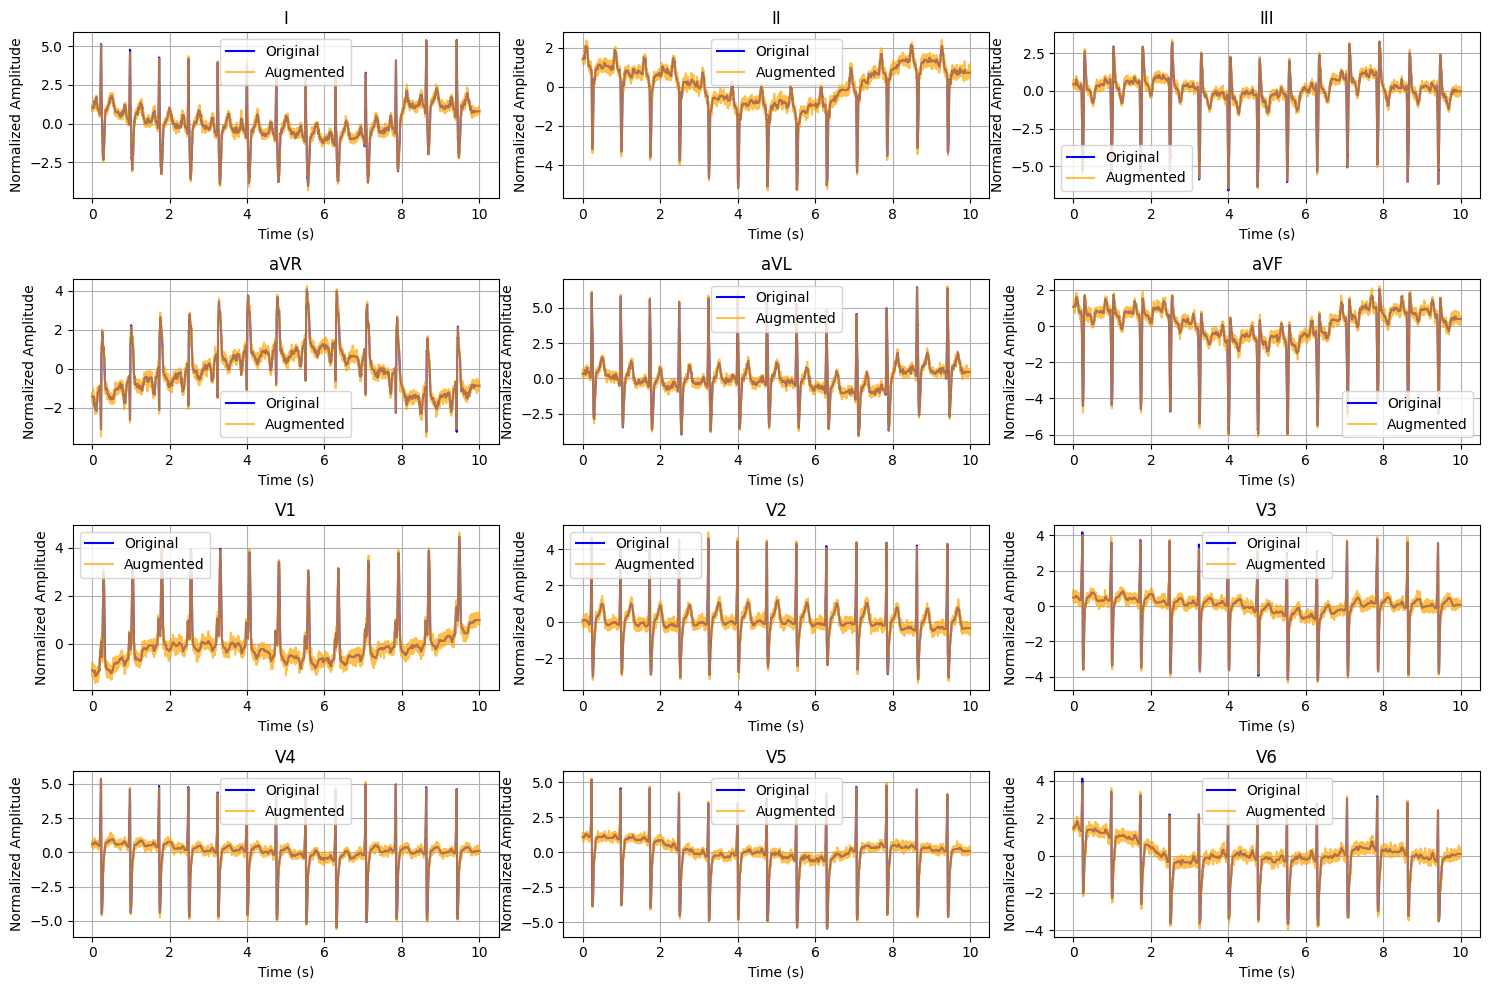

Original training set shape: (12500, 5000, 12)
Augmented training set shape: (18750, 5000, 12)


In [6]:
### **Standardize ECG Signals, only reshaping the training samples**
scaler = StandardScaler()

scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


### **Augment ECG Signals**
# This function creates extra ECG samples to balance the dataset, especially for classes with fewer examples
def augment_ecg_balanced(X, y, oversample_factor=0.5, noise_level=0.15, time_shift_max=500):
    """
    Creates additional ECG samples by applying random changes to existing signals,
    focusing on classes that are less common to balance the dataset.

    Parameters:
    - X: Input ECG signals (N samples, T time steps, C channels)
    - y: Labels (N samples, K classes)
    - oversample_factor: How many extra samples to create (e.g., 0.5 means 50% more samples)
    - noise_level: Amount of random noise to add
    - time_shift_max: Maximum steps to shift the signal in time

    Returns:
    - X_comb: Combined original and new signals
    - y_comb: Combined original and new labels
    - idxs: Indices of original samples that were augmented
    """
    N, T, C = X.shape # N: number of samples, T: time steps, C: channels (leads)
    K = y.shape[1] # K: number of classes

    # Calculate how many new samples to make
    M = int(N * oversample_factor)

    # Figuring out how common each class is
    class_freq = y.sum(axis=0) / N
    # Give more weight to rarer classes
    inv_freq = 1.0 / (class_freq + 1e-6)
    inv_freq /= inv_freq.max() # Normalizing the weights
    # Calculating weights for each sample based on its classes
    sample_w = y.dot(inv_freq)
    sample_w /= sample_w.sum()

    # Pick samples to augment, with rarer classes more likely to be chosen
    idxs = np.random.choice(N, size=M, p=sample_w, replace=True)

    # Augment selected signals
    augmented = []
    augmented_labels = []
    for idx in idxs:
        sig = X[idx].copy() # Copy the original signal
        lbl = y[idx] # Copy the original label
        # Randomly pick 2 to 3 ways to change the signal
        techniques = np.random.choice(
            ['noise', 'time_shift', 'amplitude_scale', 'invert', 'baseline_wander'],
            size=np.random.randint(2, 4), replace=False
        )
        for t in techniques:
            if t == 'noise':
                # Add small random variations to mimic real-world noise
                sig += np.random.normal(0, noise_level, sig.shape)
            elif t == 'time_shift':
                # Shift the signal left or right to simulate timing differences
                shift = np.random.randint(-time_shift_max, time_shift_max)
                sig = np.roll(sig, shift, axis=0)
            elif t == 'amplitude_scale':
                # Change the signal height to vary intensity
                sig *= np.random.uniform(0.5, 1.5)
            elif t == 'invert':
                # Flip the signal upside down sometimes (30% chance)
                if np.random.rand() < 0.3:
                    sig = -sig
            else:
                # Create a slow sine wave to simulate slow changes in the signal
                tt = np.linspace(0, 10, T)
                wander = 0.1 * np.sin(2 * np.pi * 0.1 * tt)[:, None]
                sig += wander
        augmented.append(sig)
        augmented_labels.append(lbl)

    # Stack the new samples and combine with originals
    X_aug = np.stack(augmented, axis=0)
    y_aug = np.stack(augmented_labels, axis=0)
    X_comb = np.concatenate([X, X_aug], axis=0)
    y_comb = np.concatenate([y, y_aug], axis=0)
    return X_comb, y_comb, idxs

### **Visualize ECG Signals**
# This function shows the original and augmented signals side by side for each lead
def visualize_augmented_ecg(original, augmented, lead_names, fs=500):
    """
    Visualizes the original and augmented ECG signals for each lead in separate subplots.
    
    Parameters:
    - original: Original ECG signal (time_steps, num_leads)
    - augmented: Augmented ECG signal (time_steps, num_leads)
    - lead_names: List of lead names (e.g., ['I', 'II', ...])
    - fs: Sampling frequency in Hz (default is 500)
    """
    time_steps = original.shape[0]
    num_leads = original.shape[1]
    
    # Create time axis based on sampling frequency (10 seconds)
    time = np.arange(time_steps) / fs
    
    # Create a figure with subplots: 4 rows and 3 columns for 12 leads
    fig, axes = plt.subplots(4, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(num_leads):
        ax = axes[i]
        # Plot original in blue, augmented in orange
        ax.plot(time, original[:, i], label='Original', color='blue')
        ax.plot(time, augmented[:, i], label='Augmented', color='orange', alpha=0.7)
        ax.set_title(lead_names[i])
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Normalized Amplitude')
        ax.legend()
        ax.grid(True)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


X_train_combined, y_train_combined, idxs = augment_ecg_balanced(X_train, y_train, oversample_factor=0.5, noise_level=0.15, time_shift_max=500)

# Calculate how many new samples were added
N = len(X_train) # Original number of samples
M = len(X_train_combined) - N  # Number of new samples

# Select a random augmented sample and its corresponding original
k = np.random.randint(0, M)
original_sample = X_train[idxs[k]]
augmented_sample = X_train_combined[N + k]

# Visualize
visualize_augmented_ecg(original_sample, augmented_sample, FOCUS_LEAD_NAMES, fs=500)

print(f"Original training set shape: {X_train.shape}")
print(f"Augmented training set shape: {X_train_combined.shape}")

## Data Exploration

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,CD,HYP,MI,NORM,STTC
0,1,15709.0,56.0,1,0.0,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,0,0,3,records100/00000/00001_lr,records500/00000/00001_hr,0.0,0.0,0.0,1.0,0.0
1,2,13243.0,19.0,0,0.0,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,0,0,2,records100/00000/00002_lr,records500/00000/00002_hr,0.0,0.0,0.0,1.0,0.0
2,3,20372.0,37.0,1,0.0,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,0,0,5,records100/00000/00003_lr,records500/00000/00003_hr,0.0,0.0,0.0,1.0,0.0
3,4,17014.0,24.0,0,0.0,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,0,0,3,records100/00000/00004_lr,records500/00000/00004_hr,0.0,0.0,0.0,1.0,0.0
4,5,17448.0,19.0,1,0.0,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,0,0,4,records100/00000/00005_lr,records500/00000/00005_hr,0.0,0.0,0.0,1.0,0.0


All ECG signals are 10 seconds long.


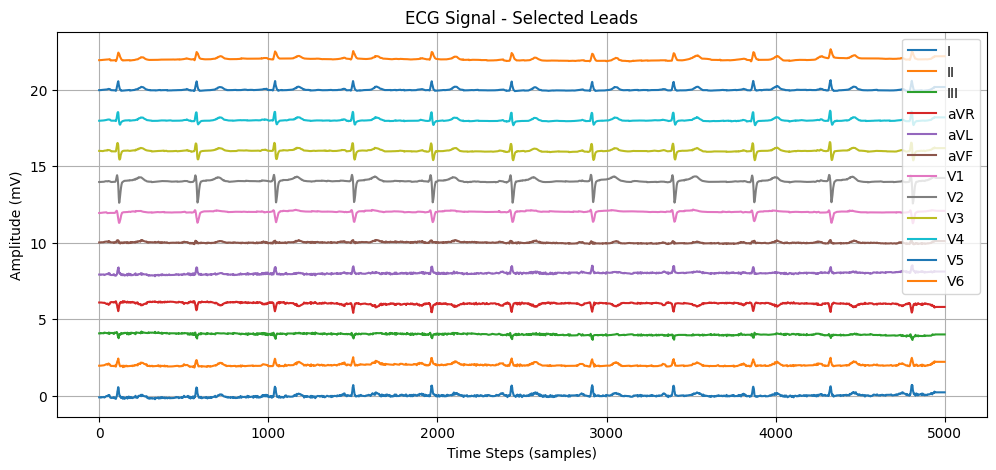

Distribution of diagnostic classes:
NORM: 9438.0 samples (43.30%)
MI: 4134.0 samples (18.96%)
STTC: 5078.0 samples (23.29%)
CD: 4891.0 samples (22.44%)
HYP: 2258.0 samples (10.36%)


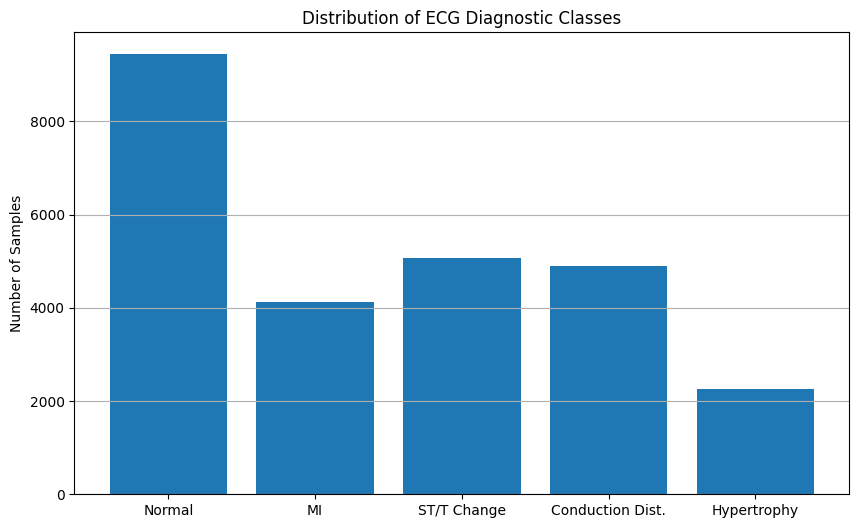

Distribution of diagnostic classes in augmented dataset:
NORM: 6768 samples (36.10%)
MI: 4568 samples (24.36%)
STTC: 5594 samples (29.83%)
CD: 5155 samples (27.49%)
HYP: 3294 samples (17.57%)


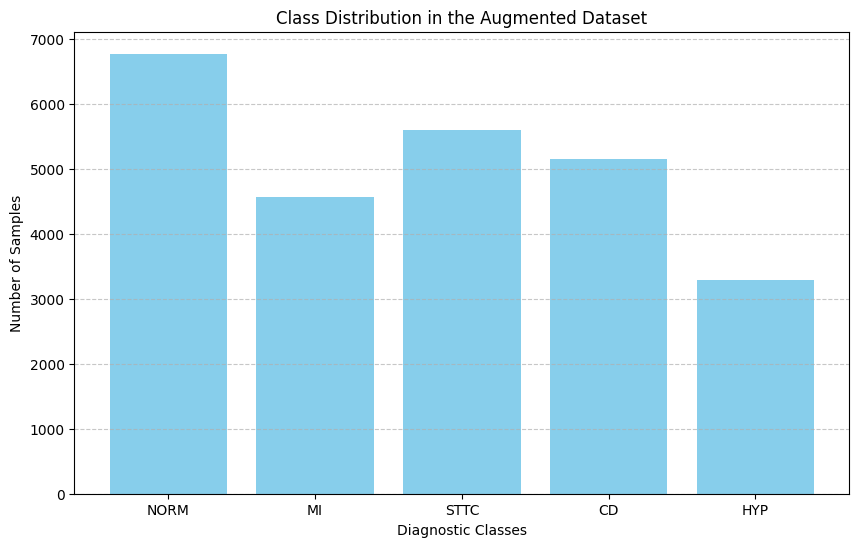

Number of multi-label records: 4390 (20.14%)


In [7]:
# Display dataset examples
display(df.head())



### Verify ECG Signal Duration
# Check if all ECG signals are exactly 10 seconds long, as expected
sampling_rate = 500  # PTB-XL default sampling rate
all_correct = True  # Flag to track if all signals are correct

# Loop through all signals and calculate their duration
for i, ecg_signal in enumerate(ecg_signals):
    duration = ecg_signal.shape[0] / sampling_rate  # Duration in seconds
    if duration != 10:
        print(f"ECG signal {i} has a duration of {duration} seconds (should be 10 seconds)")
        all_correct = False

if all_correct:
    print("All ECG signals are 10 seconds long.")



### Visualize ECG Signals
def plot_ecg(ecg_data, leads, title):
    """Plots ECG signals for selected leads with offsets to separate them"""
    plt.figure(figsize=(12, 5))
    for i in range(ecg_data.shape[1]):
        plt.plot(ecg_data[:, i] + (i * 2), label=leads[i])  # Offset between each lead
    plt.title(title)
    plt.xlabel("Time Steps (samples)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot selected leads
plot_ecg(ecg_signals[0], FOCUS_LEAD_NAMES, "ECG Signal - Selected Leads")


### Analyze Class Distribution
# Calculate how many samples belong to each diagnostic class
print("Distribution of diagnostic classes:")
for diagnostic_class in target_columns:
    count = df[diagnostic_class].sum() # Sum of 1s in the column ("True" values)
    percent = 100 * count / len(df) # Percentage of total samples
    print(f"{diagnostic_class}: {count} samples ({percent:.2f}%)")

plt.figure(figsize=(10, 6))
label_counts = [df[col].sum() for col in target_columns]
plt.bar(["Normal", "MI", "ST/T Change", "Conduction Dist.", "Hypertrophy"], label_counts)
plt.title("Distribution of ECG Diagnostic Classes")
plt.ylabel("Number of Samples")
plt.grid(axis="y")
plt.show()



### Analyze Class Distribution after Augmentation
print("Distribution of diagnostic classes in augmented dataset:")
label_counts_train = [y_train_combined[:, i].sum() for i in range(y_train_combined.shape[1])]
total_samples_train = len(y_train_combined)
# Print class distribution
for diagnostic_class, count in zip(target_columns, label_counts_train):
    percent = 100 * count / total_samples_train
    print(f"{diagnostic_class}: {int(count)} samples ({percent:.2f}%)")

plt.figure(figsize=(10, 6))
plt.bar(target_columns, label_counts_train, color='skyblue')
plt.title("Class Distribution in the Augmented Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Diagnostic Classes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### Check for Multi-Label Records
# Count how many ECG records have more than one diagnostic label
multi_label_count = (df[target_columns].sum(axis=1) > 1).sum()
print(f"Number of multi-label records: {multi_label_count} ({100*multi_label_count/len(df):.2f}%)")

## Model Training

In [8]:
# --- Residual Block Definition (Unchanged) ---
def residual_block(x, filters, kernel_size=5, dilation_rate=1, pool_size=2, dropout_rate=0.3, pool=True):
    """
    A residual block for 1D CNNs, enabling the model to learn complex patterns by adding shortcut connections.

    Parameters:
    - x: Input tensor
    - filters: Number of filters in the convolutional layers (controls the depth of features)
    - kernel_size: Size of the convolutional kernel (default: 5)
    - dilation_rate: Dilation factor for convolutions (default: 1, increases receptive field if > 1)
    - pool_size: Size of the max pooling window (default: 2)
    - dropout_rate: Fraction of units to drop for regularization (default: 0.3)
    - pool: Whether to apply max pooling (default: True)

    Returns:
    - Output tensor after processing through the residual block
    """
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    # Adjust shortcut if the number of filters differs from the input
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
    # Add the shortcut to the processed output (residual connection)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    if pool:
        x = MaxPooling1D(pool_size)(x)
    return x

# ** Model Architecture **
inputs = Input(shape=X_train.shape[1:])
x = residual_block(inputs, 32, pool=True)
x = residual_block(x, 64, pool=False)
x = residual_block(x, 128, dilation_rate=2, pool=True)
x = residual_block(x, 256, pool=False)
x = residual_block(x, 512, pool=True)

x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs, outputs)


# ** Compile the Model **
# Calculate class weights based on training data imbalance
positive_rates = np.mean(y_train, axis=0)
alpha_per_class = tf.constant(1 - positive_rates, dtype=tf.float32)

def focal_loss(gamma=3.0, alpha=alpha_per_class):
    """
    Focal loss function for multi-label classification.

    Parameters:
    - gamma: Parameter for focusing on hard examples (default: 3.0)
    - alpha: Class weights to balance positive/negative classes

    Returns:
    - Loss function
    """
    def loss(y_true, y_pred):
        eps = tf.keras.backend.epsilon() # Small value to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, eps, 1-eps) # Clip predictions
        alpha_t = tf.convert_to_tensor(alpha, tf.float32)
        if alpha_t.shape.rank == 1:
            alpha_t = tf.reshape(alpha_t, [1, -1])  # Reshape for broadcasting
        alpha_t = tf.broadcast_to(alpha_t, tf.shape(y_true))
        # Probability of the true class (pt)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        # Weight based on alpha (class weights)
        w = tf.where(tf.equal(y_true, 1), alpha_t, 1-alpha_t)
        # Focal loss formula
        return tf.reduce_mean(-w * tf.pow(1-pt, gamma) * tf.math.log(pt))
    return loss

model.compile(
    loss=focal_loss(gamma=3.0, alpha=alpha_per_class),
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
    metrics=[
        AUC(curve='PR', name='pr_auc', summation_method='minoring'),
        F1Score(average='micro', name='micro_f1'),
        F1Score(average='macro', name='macro_f1'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()

callbacks = [
    ReduceLROnPlateau(monitor='val_macro_f1', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_macro_f1', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_macro_f1', save_best_only=True)
]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5000, 32)  │      1,952 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5000, 32)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5000, 32)  │        128 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 5000, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5000, 32)  │      5,152 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5000, 32)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 32)  │        128 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5000, 32)  │        416 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5000, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 5000, 32)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 2500, 32)  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2500, 64)  │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2500, 64)  │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 64)  │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 2500, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2500, 64)  │     20,544 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2500, 64)  │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 64)  │        256 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2500, 64)  │      2,112 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2500, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_5[0][0]  

 Total params: 2,869,925 (10.95 MB)

 Trainable params: 2,865,957 (10.93 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1491s 5s/step - loss: 0.4019 - macro_f1: 0.2985 - micro_f1: 0.3336 - pr_auc: 0.3874 - precision: 0.3427 - recall: 0.7270 - val_loss: 0.0350 - val_macro_f1: 0.2366 - val_micro_f1: 0.4673 - val_pr_auc: 0.5083 - val_precision: 0.5190 - val_recall: 0.4740 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1440s 5s/step - loss: 0.0331 - macro_f1: 0.3726 - micro_f1: 0.4193 - pr_auc: 0.4942 - precision: 0.3935 - recall: 0.8184 - val_loss: 0.0293 - val_macro_f1: 0.3241 - val_micro_f1: 0.5334 - val_pr_auc: 0.5866 - val_precision: 0.5065 - val_recall: 0.6823 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1439s 5s/step - loss: 0.0309 - macro_f1: 0.3963 - micro_f1: 0.4583 - pr_auc: 0.5240 - precision: 0.4049 - recall: 0.8301 - val_loss: 0.0306 - val_macro_f1: 0.3376 - val_micro_f1: 0.5169 - val_pr_auc: 0.5676 - val_precision: 0.4551 - val_recall: 0.6963 - learning_rate: 0.0010
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1455s 5s/ste

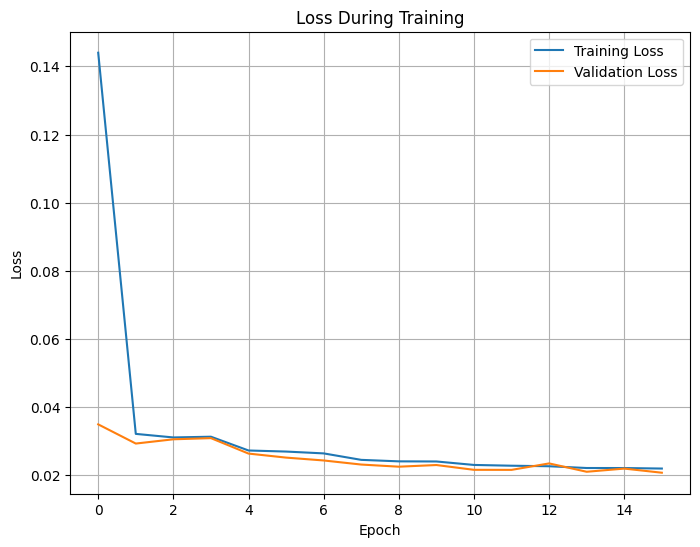

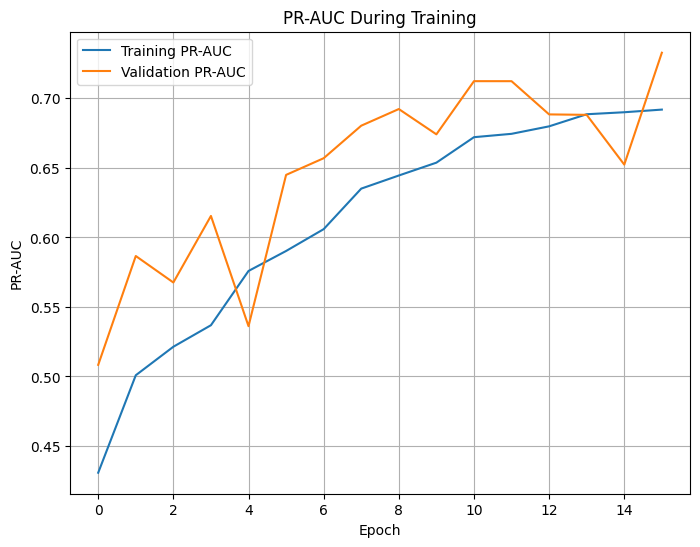

In [9]:
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['pr_auc'], label='Training PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Validation PR-AUC')
plt.title('PR-AUC During Training')
plt.xlabel('Epoch')
plt.ylabel('PR-AUC')
plt.legend()
plt.grid(True)
plt.show()

103/103 ━━━━━━━━━━━━━━━━━━━━ 52s 504ms/step - loss: 0.0208 - macro_f1: 0.5108 - micro_f1: 0.6668 - pr_auc: 0.7568 - precision: 0.5613 - recall: 0.8094
Test set evaluation:
loss: 0.0217
compile_metrics: 0.7064
103/103 ━━━━━━━━━━━━━━━━━━━━ 52s 499ms/step

Classification Report:
               precision    recall  f1-score   support

        NORM       0.73      0.92      0.81      1416
          MI       0.42      0.84      0.56       620
        STTC       0.62      0.70      0.66       761
          CD       0.44      0.75      0.55       734
         HYP       0.23      0.78      0.35       338

   micro avg       0.50      0.82      0.62      3869
   macro avg       0.49      0.80      0.59      3869
weighted avg       0.56      0.82      0.65      3869
 samples avg       0.60      0.77      0.64      3869

Per-class Precision-Recall AUC:
  NORM: 0.8684
  MI: 0.6016
  STTC: 0.6921
  CD: 0.5884
  HYP: 0.4788


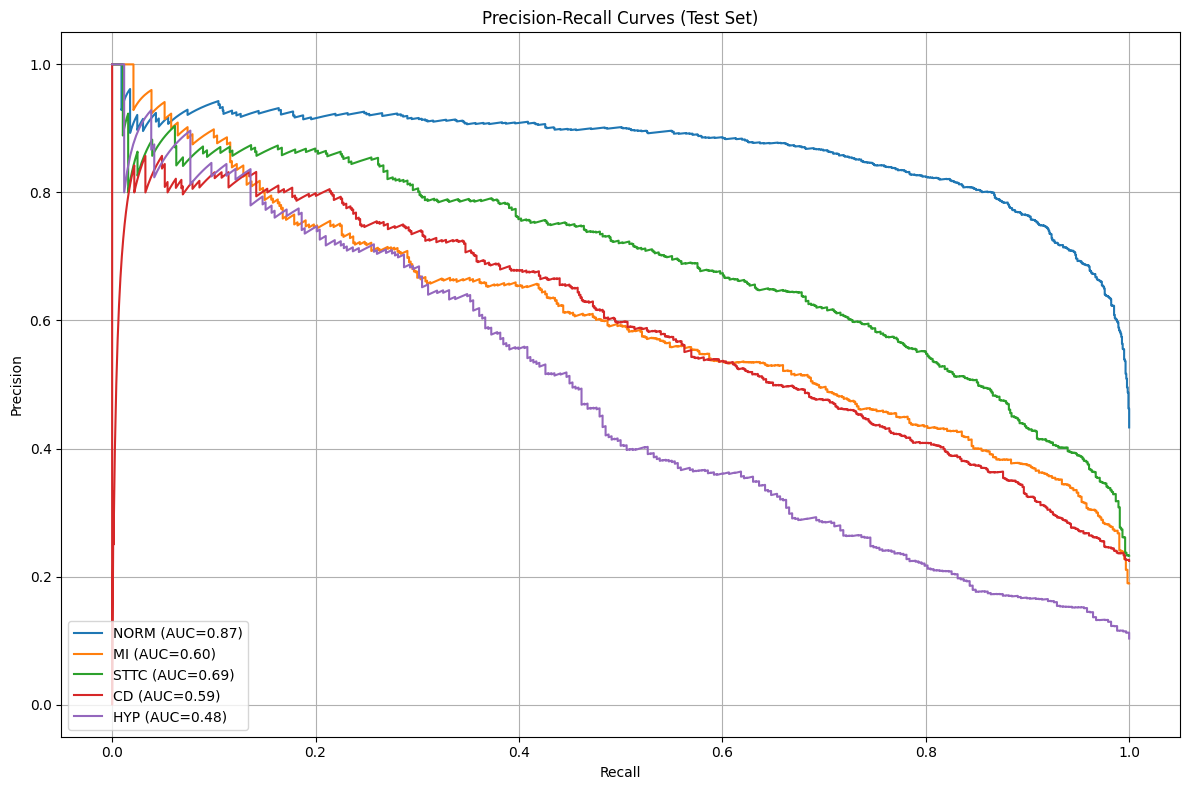

In [10]:
# Evaluate loss & metrics already logged
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test set evaluation:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predict probabilities and binary outputs
y_pred_prob = model.predict(X_test, batch_size=32)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Classification report
report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=target_columns,
    zero_division=0
)
print("\nClassification Report:\n", report)

# Compute per-class PR-AUC
pr_aucs = {col: average_precision_score(y_test[:, i], y_pred_prob[:, i])
           for i, col in enumerate(target_columns)}
print("Per-class Precision-Recall AUC:")
for col, score in pr_aucs.items():
    print(f"  {col}: {score:.4f}")

# Plot PR curves for each class
plt.figure(figsize=(12, 8))
for i, col in enumerate(target_columns):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
    pr_auc = pr_aucs[col]
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.2f})")

plt.title('Precision-Recall Curves (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


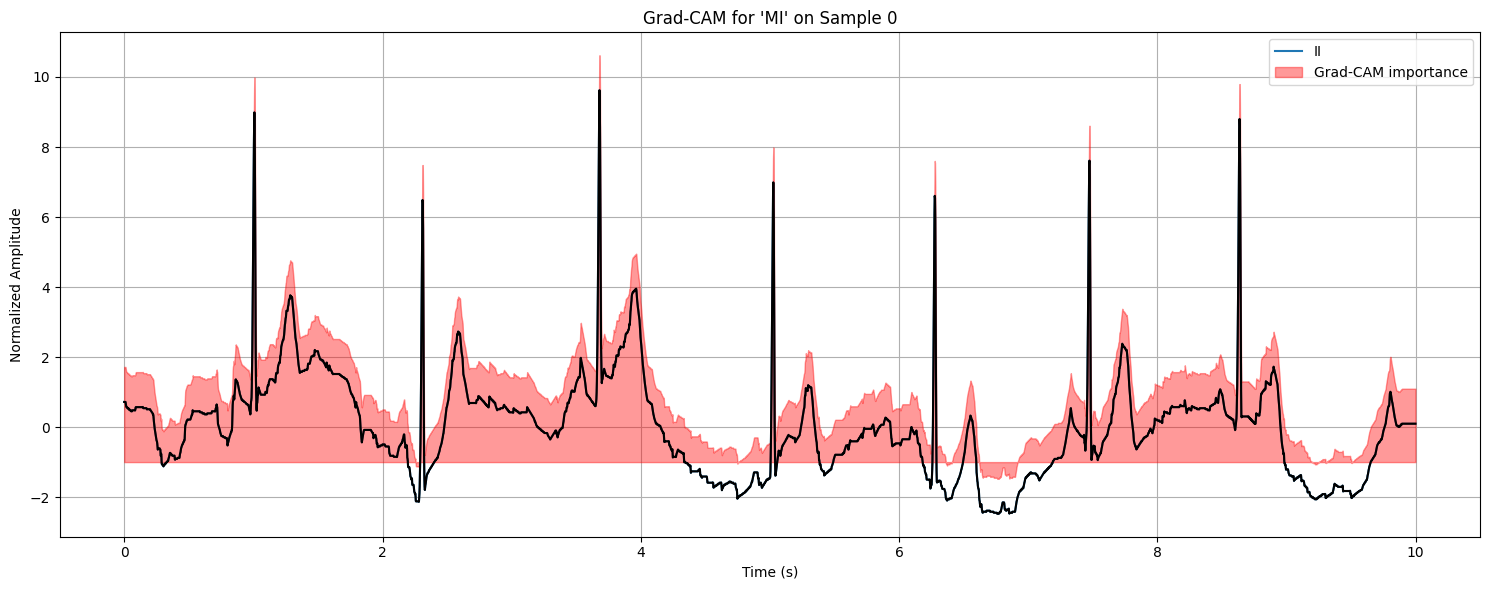

Grad-CAM computation and visualization complete.


In [ ]:
def compute_gradcam_1d(model, sample, class_index, layer_name=None):
    """
    Computes a Grad-CAM heatmap for our 1D CNN, highlighting important regions in the input signal.

    Parameters:
    - model: The trained 1D CNN model.
    - sample: A single ECG sample (shape: (T, C), where T is time steps, C is channels).
    - class_index: Index of the class to generate the heatmap for (e.g., index of 'MI').
    - layer_name: Name of the convolutional layer to use (default: last Conv1D layer).

    Returns:
    - cam: A 1D heatmap (shape: (T,)) indicating important regions in the signal.
    """
    # Find the last Conv1D layer if not specified
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, Conv1D):
                layer_name = layer.name
                break

    # Building a model that outputs the convolutional layer's activations and the final predictions
    conv_layer = model.get_layer(layer_name)
    grad_model = Model(inputs=model.input,
                       outputs=[conv_layer.output, model.output])

    # Compute gradients with respect to the class of interest
    inp = tf.expand_dims(sample, axis=0) # Adds batch dimension: (1, T, C)
    with tf.GradientTape() as tape:
        conv_outs, preds = grad_model(inp) # Get conv outputs and predictions
        loss = preds[:, class_index] # Focus on the specified class
    grads = tape.gradient(loss, conv_outs) # Gradients of loss w.r.t. conv outputs

    # Compute weights and create the heatmap
    weights = tf.reduce_mean(grads, axis=1) # Average gradients over time: (1, filters)
    # Compute the heatmap by using weighted sum of conv feature maps
    cam = tf.reduce_sum(conv_outs * weights[:, None, :], axis=-1)[0]

    # Apply ReLU and normalize the heatmap
    # Apply ReLU to the heatmap to keep only positive contributions
    cam = tf.nn.relu(cam)
    cam -= tf.reduce_min(cam)
    cam /= tf.reduce_max(cam) + 1e-8

    # Upsample the heatmap to match the original signal's time steps
    T = sample.shape[0]
    # Since the convolutional layer may have a different number of time steps due to pooling,
    # we've resized the heatmap to match the original input's time steps
    cam = tf.image.resize(cam[None, :, None], (T, 1),
                          method='bilinear')[0, :, 0]
    return cam.numpy()                         # shape (T,)

### **Visualize Grad-CAM on example lead (Lead II)**
# Select a sample from the test set (sample index 0)
sample_idx = 0
sample = X_test[sample_idx]                     # shape (T, C)
class_idx = target_columns.index('MI')

cam_map = compute_gradcam_1d(model, sample, class_idx)


fs = 500 # Sampling frequency in Hz
time = np.arange(sample.shape[0]) / fs # Time axis in seconds

lead_idx = 1 # Index for Lead II
offset = 0 # Offset for plotting

# Create y1 and y2 for the fill_between function
y1 = np.full_like(time, offset - 1.0)  # Constant value below the signal
y2 = sample[:, lead_idx] + offset + 1.0  # Signal shifted up

# Identify regions where the heatmap value is significant (above 0.01),
# to highlight important parts of the signal in the plot.
mask = cam_map >= 0.01  # Tunable threshold for significance
if mask.shape != time.shape:
    mask = np.broadcast_to(mask, time.shape)

# debug check (optional):
# print(f"time: {time.shape}, y1: {y1.shape}, y2: {y2.shape}, mask: {mask.shape}")


# Plot the ECG signal with Grad-CAM heatmap overlay
plt.figure(figsize=(15, 6))
plt.plot(time, sample[:, lead_idx] + offset,
         label=FOCUS_LEAD_NAMES[lead_idx])

# We use fill_between to shade the areas where the heatmap indicates high importance,
# showing which parts of the ECG signal the model focused on for its prediction.
plt.fill_between(time, y1, y2,
                 where=mask,
                 color='red', alpha=0.4,
                 zorder=2,               # draw it on top
                 label='Grad-CAM importance')
# Ensure the ECG signal is on top
plt.plot(time, sample[:,lead_idx]+offset,
         color='black', zorder=3)

plt.title(f"Grad-CAM for '{target_columns[class_idx]}' on Sample {sample_idx}")
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Grad-CAM computation and visualization complete.")